# Approximate Nearest Neighbours with FAISS
In this notebook, we're going to learn how to do approximate nearest neighbours in FAISS using a cell probe method.

In [493]:
!pip install faiss-cpu pandas numpy

In [494]:
import faiss
import copy
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly_functions import generate_distinct_colors, zoom_in, create_plot, plot_points

In [495]:
dimensions = 2
number_of_vectors = 10_000
vectors = np.random.random((number_of_vectors, dimensions)).astype(np.float32)

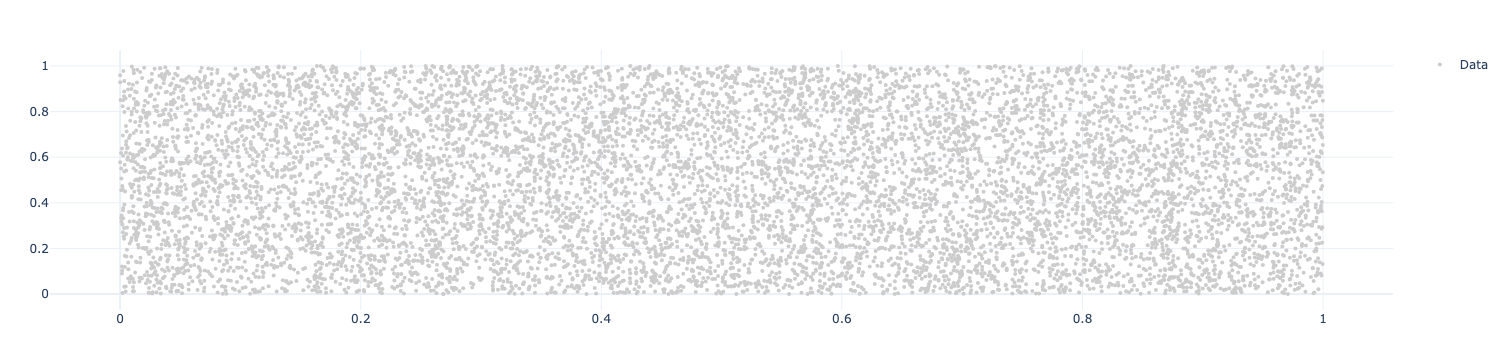

In [496]:
fig = create_plot()
plot_points(fig, points=vectors, color='#CCCCCC', label="Data")
fig

In [497]:
search_vector = np.array([[0.5, 0.5]])

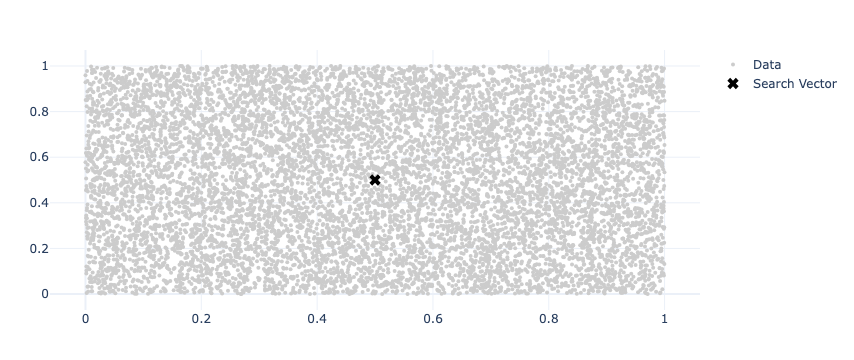

In [498]:
plot_points(fig, points=search_vector, color='black', label="Search Vector", symbol="x", size=10)
fig

## Creating a cell probe index
When creating the index, we need to specify how many partitions (or cells) we want to divide the vector space into.

In [499]:
cells = 10

quantizer = faiss.IndexFlatL2(dimensions)
index = faiss.IndexIVFFlat(quantizer, dimensions, cells)

In [500]:
index.train(vectors)

In [501]:
centroids = index.quantizer.reconstruct_n(0, index.nlist)
centroids

array([[0.8503718 , 0.46587527],
       [0.14201212, 0.80757564],
       [0.831061  , 0.82165515],
       [0.5756452 , 0.54481953],
       [0.5543639 , 0.1812697 ],
       [0.84584594, 0.16083847],
       [0.259557  , 0.5097532 ],
       [0.23731372, 0.12491277],
       [0.47171366, 0.8513159 ],
       [0.08305518, 0.30214617]], dtype=float32)

## Visualising cells and centroids
Let's update our chart to show the centroids and to which cell each vector will be assigned.

In [502]:
_, cell_ids = index.quantizer.search(vectors, k=1)
cell_ids = cell_ids.flatten()
cell_ids[:10]

array([0, 4, 3, 1, 1, 8, 9, 4, 0, 9])

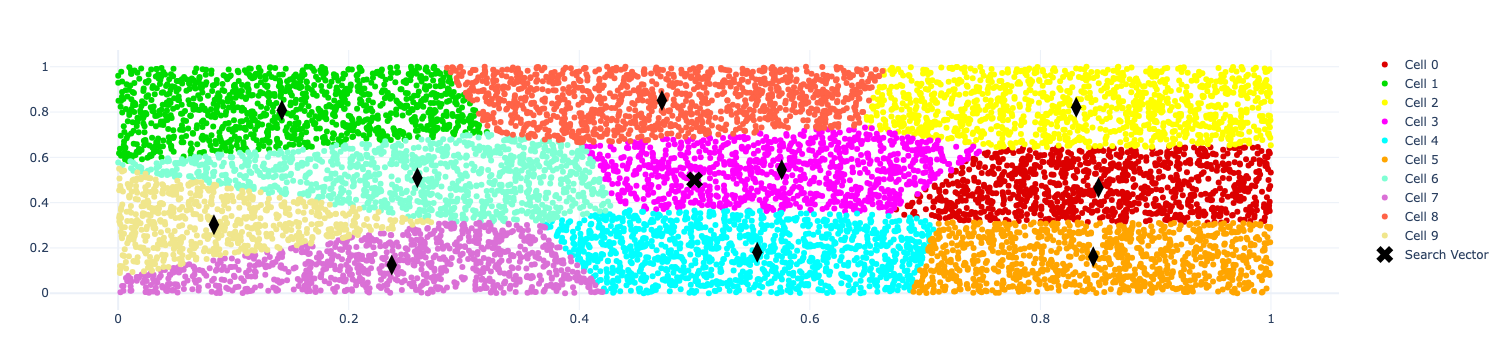

In [532]:
color_map = generate_distinct_colors(index.nlist)

fig_cells = create_plot()

unique_ids = np.unique(cell_ids)
for uid in unique_ids:
  mask = (cell_ids == uid)
  masked_vectors = vectors[mask]
  plot_points(fig_cells, masked_vectors, color_map[uid], "Cell {}".format(uid), size=6)

plot_points(fig_cells, centroids, symbol="diamond-tall", color="black", size=15, showlegend=False)
plot_points(fig_cells, search_vector, symbol="x", color="black", size=15, label="Search Vector")

fig_cells

In [520]:
!pip install kaleido

In [533]:
import plotly.io as pio

current_width = fig_cells.layout.width
current_height = fig_cells.layout.height
print(current_width, current_height)


pio.orca.config.executable = '/usr/local/bin/orca'  # Replace with the actual path to your Orca executable


desired_width = 1600  # or whatever width you prefer in pixels
scaling_factor = desired_width / current_width if current_width else None

# If you know the current width, scale the height proportionally.
desired_height = current_height * scaling_factor if current_height and scaling_factor else None
fig_cells.update_layout(showlegend=False)
fig_cells.update_layout(template="plotly_white", margin=dict(t=0, b=0, l=0, r=0))
pio.write_image(fig_cells, 'figure_high_res.png', width=1280, height=720, scale=3.0)


None None


## Searching for our vector
Let's add the vectors to the index and look for our search vector.

In [504]:
index.add(vectors)

When using a cell probe index, we can specify how many cells we want to use in the search. More cells will mean a slower, but potentially more accurate search.

In [505]:
index.nprobe

1

In [506]:
%%time 
distances, indices = index.search(search_vector, k=10)

df_ann = pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
})
df_ann

CPU times: user 726 µs, sys: 507 µs, total: 1.23 ms
Wall time: 1.31 ms


id                    vector  distance
0  5212  [0.49697843, 0.49814904]  0.000013
1  8799   [0.49676004, 0.5018034]  0.000014
2  1553  [0.50321424, 0.49744475]  0.000017
3  8457   [0.4928198, 0.50775784]  0.000112
4  9626   [0.5133499, 0.50718963]  0.000230
5  9408    [0.49085045, 0.512838]  0.000249
6  8177  [0.48392993, 0.49651426]  0.000270
7  1959    [0.502832, 0.51659614]  0.000283
8  5451   [0.48319575, 0.5047141]  0.000305
9  4580  [0.51834625, 0.49356925]  0.000378

In [507]:
_, search_vectors_cell_ids = index.quantizer.search(search_vector, k=1)
unique_searched_ids = search_vectors_cell_ids[0]
unique_searched_ids

array([3])

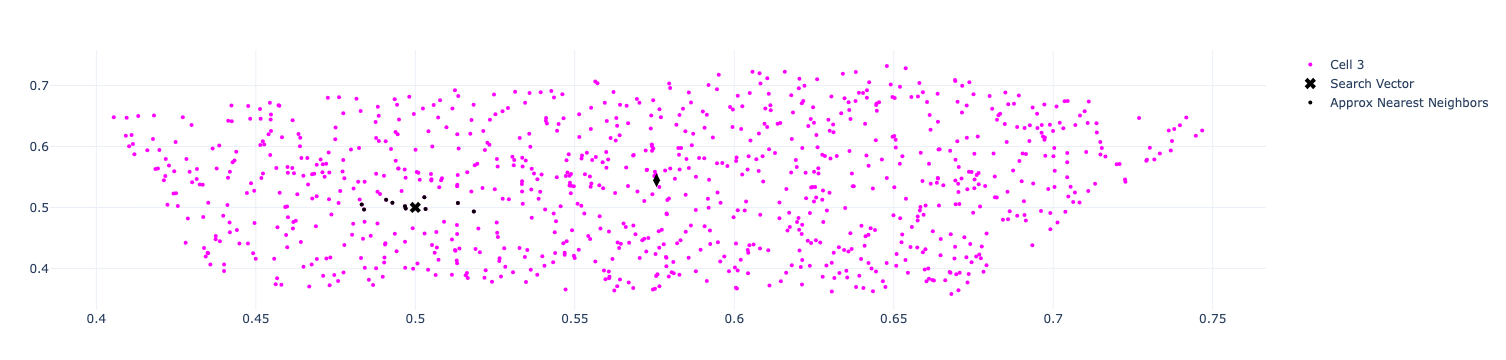

In [508]:
fig_search = create_plot()

for uid in unique_searched_ids:
  mask = (cell_ids == uid)
  masked_vectors = vectors[mask]
  plot_points(fig_search, masked_vectors, color_map[uid], label="Cell {}".format(uid))
  plot_points(fig_search, centroids[uid].reshape(1, -1), symbol="diamond-tall", color="black", size=10, label="Centroid for Cell {}".format(uid), showlegend=False)

plot_points(fig_search, points=search_vector, color='black', label="Search Vector", symbol="x", size=10)

ann_vectors = np.array(df_ann["vector"].tolist())
plot_points(fig_search, points=ann_vectors, color='black', label="Approx Nearest Neighbors")

fig_search

# Brute Force Nearest Neighbours
How well did this approach work compared to a brute force one?

In [509]:
brute_force_index = faiss.IndexFlatL2(dimensions)
brute_force_index.add(vectors)

In [510]:
%%time
distances, indices = brute_force_index.search(search_vector, k=10)

pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
  "cell": [cell_ids[id] for id in indices[0]]
})

CPU times: user 1.21 ms, sys: 183 µs, total: 1.39 ms
Wall time: 1.87 ms


id                    vector  distance  cell
0  5212  [0.49697843, 0.49814904]  0.000013     3
1  8799   [0.49676004, 0.5018034]  0.000014     3
2  1553  [0.50321424, 0.49744475]  0.000017     3
3  8457   [0.4928198, 0.50775784]  0.000112     3
4  9626   [0.5133499, 0.50718963]  0.000230     3
5  9408    [0.49085045, 0.512838]  0.000249     3
6  8177  [0.48392993, 0.49651426]  0.000270     3
7  1959    [0.502832, 0.51659614]  0.000283     3
8  5451   [0.48319575, 0.5047141]  0.000305     3
9  4580  [0.51834625, 0.49356925]  0.000378     3

In [511]:
index.nprobe = 2

In [512]:
index.quantizer.search(search_vector, k=2)

(array([[0.00773099, 0.05790796]], dtype=float32), array([[3, 6]]))

In [513]:
%%time
distances, indices = index.search(search_vector, k=10)

pd.DataFrame({
  "id": indices[0],
  "vector": [vectors[id] for id in indices[0]],
  "distance": distances[0],
  "cell": [cell_ids[id] for id in indices[0]]
})

CPU times: user 982 µs, sys: 175 µs, total: 1.16 ms
Wall time: 2.34 ms


id                    vector  distance  cell
0  5212  [0.49697843, 0.49814904]  0.000013     3
1  8799   [0.49676004, 0.5018034]  0.000014     3
2  1553  [0.50321424, 0.49744475]  0.000017     3
3  8457   [0.4928198, 0.50775784]  0.000112     3
4  9626   [0.5133499, 0.50718963]  0.000230     3
5  9408    [0.49085045, 0.512838]  0.000249     3
6  8177  [0.48392993, 0.49651426]  0.000270     3
7  1959    [0.502832, 0.51659614]  0.000283     3
8  5451   [0.48319575, 0.5047141]  0.000305     3
9  4580  [0.51834625, 0.49356925]  0.000378     3